Assumption: we already have a model fitted. We want to take the coefficients (or SHAP values, same principle) and plot them against the raw averages of the data. 

The challenge is going to be multiple scales (which unlike ggplot should be possible in matplotlib I think...)

Categorical is more straightforward, let's start with that. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from functions import load_mtpl2

# Generate Data

In [2]:
df = load_mtpl2()

In [3]:
df.sample(3)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
IDpol,,,,,,,,,,,,
2280509,0,0.97,E,8,18,39,66,B1,Diesel,5460,R11,0.0
4011438,0,0.20,E,6,3,55,51,B12,Regular,4646,R82,0.0
1197672,0,0.39,E,7,0,62,52,B2,Regular,3963,R91,0.0


In [4]:
df.Area.value_counts()

C    191880
D    151596
E    137167
A    103957
B     75459
F     17954
Name: Area, dtype: int64

In [5]:
coef_df_cat = pd.DataFrame.from_dict({
    "Area": list(set(df.Area)),
    "coef": [1,1.2,0.8,1.15,2,0.75]
})

In [11]:
# for the function, coefs need to be already merged on...

df = df.merge(coef_df_cat, on = "Area", how = "left")

# Prototyping Plot Data - Categorical

In [6]:
df2 = df.groupby("Area").agg(
    raw_average = ("ClaimAmount", np.mean), 
    exposure = ("ClaimNb", "count"))

In [7]:
plot_df = coef_df_cat.copy()
plot_df.sort_values("Area", inplace = True)
plot_df = plot_df.merge(df2, on = "Area", how = "left")

In [8]:
# need to recode exposure, we can't put on a third scale
# going to put it on the ax2
# exposures start from the lowest ax2 point, i.e. the lowest average claimamount point
# and they should go up till maybe 70% of the max

# re-scale it somehow..

min_on_scale = np.min(plot_df.raw_average)
max_on_scale = np.max(plot_df.raw_average)
max_exposure = np.max(plot_df.exposure)

plot_df["exposure"] = min_on_scale + (max_on_scale - min_on_scale) * plot_df["exposure"] / max_exposure


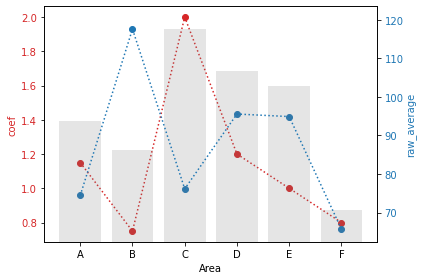

In [9]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel("Area")
ax1.set_ylabel('coef', color=color)
ax1.scatter(plot_df.Area,plot_df.coef, color = color)
ax1.plot(plot_df.Area,plot_df.coef, color = color, linestyle = ":")
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.set_ylim(min_on_scale * 0.95, max_on_scale * 1.05)

color = 'tab:blue'
ax2.set_ylabel('raw_average', color=color)
ax2.scatter(plot_df.Area,plot_df.raw_average, color = color)
ax2.plot(plot_df.Area,plot_df.raw_average, color = color, linestyle = ":")
ax2.tick_params(axis='y', labelcolor=color)

ax2.bar(plot_df.Area,plot_df.exposure, color = "grey", alpha = 0.2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

# Categorical Function

We want a table first, then we can do the plotting. 

In [34]:
def get_coefficient_analysis_plot_table_categorical(
    cat_feature, target, exposure, coef, cat_feature_name, target_name):
    """
    Bit of a weird structure. These are all assumed to be vectors of the same size. 
    So coef is already merged on the cat feature, meaning there is going to be some repetition. 
    The alternative would be to request two dataframes of different sizes, but I think that would be 
    confusing... This way, we can get everything we want with one aggregation. 
    """
    
    df = pd.DataFrame.from_dict({
        "cat_feature": cat_feature,
        "target": target,
        "exposure" : exposure, 
        "coef": coef
    })
    
    # group by the cat feature, that is what we want to plot
    df = df.groupby("cat_feature").agg(
        target_average = ("target", np.mean), 
        exposure = ("exposure", np.sum),
        coef = ("coef", lambda x: x.iloc[0]))
    
    # re-code exposure so it fits the chart
    # # exposures start from the lowest ax2 point, i.e. the lowest average claimamount point
    # and they should go up till maybe 70% of the max

    min_on_scale = np.min(df.target_average)
    max_on_scale = np.max(df.target_average)
    max_exposure = np.max(df.exposure)

    df["exposure"] = min_on_scale + (max_on_scale - min_on_scale) * df["exposure"] / max_exposure
    
    df.reset_index(inplace = True)
    
    df.rename(columns = {"cat_feature": cat_feature_name, 
                         "target_average": target_name + "_average"}, 
              inplace = True)
    
    return df

In [35]:
temp = get_coefficient_analysis_plot_table_categorical(df.Area, df.ClaimAmount, 1, df.coef, 
                                                      "area", "total_claim_amount")
temp

,area,total_claim_amount_average,exposure,coef
0,A,74.450308,93.819189,1.15
1,B,117.600015,86.111240,0.75
2,C,76.152139,117.600015,2.00
3,D,95.559917,106.704268,1.20
4,E,94.902027,102.801608,1.00
5,F,65.701594,70.557672,0.80


In [40]:
def get_coefficient_analysis_plot_categorical(plot_df, cat_feature_name, target_name):
    """
    Creates the plot based on the previous function. 
    """
    
    target_name = target_name + "_average" # this solution does not scream stabiity to me... 
    
    fig = plt.figure()
    
    ax1 = fig.add_subplot(1,1,1)

    color = 'tab:red'
    ax1.set_xlabel(cat_feature_name)
    ax1.set_ylabel('coef', color=color)
    ax1.scatter(plot_df[cat_feature_name],plot_df["coef"], color = color)
    ax1.plot(plot_df[cat_feature_name],plot_df["coef"], color = color, linestyle = ":")
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()

    ax2.set_ylim(min_on_scale * 0.95, max_on_scale * 1.05)

    color = 'tab:blue'
    ax2.set_ylabel(target_name, color=color)
    ax2.scatter(plot_df[cat_feature_name],plot_df[target_name], color = color)
    ax2.plot(plot_df[cat_feature_name],plot_df[target_name], color = color, linestyle = ":")
    ax2.tick_params(axis='y', labelcolor=color)

    ax2.bar(plot_df[cat_feature_name],plot_df["exposure"], color = "grey", alpha = 0.2)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    return fig

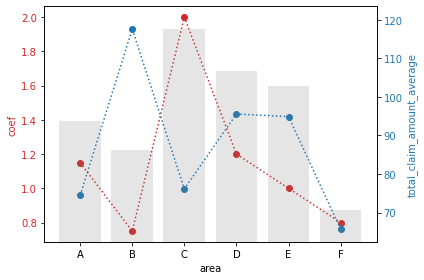

In [41]:
fig = get_coefficient_analysis_plot_categorical(temp, "area", "total_claim_amount")

# Continuous Features

Based on the above, there should be an automatic solution for cont. features. We can bin them, calculate average as if they were a categorical variable, and for the coef,... maybe do the coef of the middle? Or do an avearage of the calculated coefs in the bin... If it's the latter, need to be careful, make it a geometric mean. 